<a href="https://colab.research.google.com/github/alex-hse-repository/Information_System/blob/main/%D0%98%D0%BC%D0%B8%D1%82%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Библиотеки

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)

from scipy.stats import expon
from scipy.stats import chisquare

# Класс симмуляционной модели

In [11]:
class Statistics:
    def __init__(self, N, k):
        self.utilization = 0
        self.utilizations = np.zeros(N)
        
        self.lost_customers = np.zeros(k,dtype=int)
        self.served_customers = np.zeros(k,dtype=int)
        self.cutomers_num = 0

        self.lost_probs = np.zeros(k)
        self.destribution = {}

        self.arrivals = [[],[],[]]
        self.intervals = [[],[],[]]

        
    def lose(self,client_type):
        self.lost_customers[client_type]+=1
    def serve(self,client_type):
        self.served_customers[client_type]+=1 
    def arrive(self,client_type,time):
        self.arrivals[client_type].append(time)
        self.arrivals[-1].append(time)      

    def count_stats(self,duaration):
        #self.utilisations = np.sum(self.service_times,axis=1)/duaration
        #self.utilization = np.mean(self.utilizations)
        #self.cutomers_num = np.sum(self.lost_customers)+np.sum(np.sum(self.served_customers))

        #Расчет интервалов прибытия
        for i in range(3): 
            self.intervals[i] = np.array(self.arrivals[i])[1:]-np.array(self.arrivals[i])[:-1]
        
        #Расчет вероятностей потерь
        self.cutomers_num = self.lost_customers+self.served_customers
        self.lost_probs = self.lost_customers/self.cutomers_num

        #Нормализация распределения
        total = 0
        for state in self.destribution:
            total+=self.destribution[state]
        for state in self.destribution:
            self.destribution[state]/=total

    def update_destribution(self,cur_state):
        if(cur_state in self.destribution):
            self.destribution[cur_state]+=1
        else:
            self.destribution[cur_state]=1

In [15]:
class Simulation:
    def __init__(self,N,g,lambdas,mus,duaration):
        self.N = N
        self.g = g
        self.k = len(mus)
        self.stats = Statistics(N,self.k)
        self.clock = 0.0
        self.duaration = duaration
        self.reserved = N-g
        self.lambdas = lambdas
        self.mus = mus
        self.X = np.zeros(self.k,dtype=int)
        self.arrival_evt = self.gen_arrival()
        self.servers = np.array([{'client_type':-1,'time':np.inf} for _ in range(N)])

    def arrival(self):
        client_type = self.arrival_evt['client_type']
        time = self.arrival_evt['time']
        self.stats.arrive(client_type,time)
        if(self.arrival_is_possible(client_type)):
            self.stats.serve(client_type)
            server_id = self.get_server()
            self.X[client_type]+=1
            self.servers[server_id] = {'client_type':client_type,'time':self.gen_departure(client_type)}
        else:
            self.stats.lose(client_type)
        self.arrival_evt = self.gen_arrival()
    
    def departure(self,server_id):
        client_type = self.servers[server_id]['client_type']
        self.X[client_type]-=1
        self.servers[server_id] = {'client_type':-1,'time':np.inf}        

    def arrival_is_possible(self,client_type):
        free = self.N-np.sum(self.X)
        if(client_type==0):
            return free>self.reserved
        return free>0    
    def get_server(self):
        for server_id in range(self.N):
            if(self.servers[server_id]['client_type']==-1):
                return server_id

    def gen_arrival(self):
        times = self.clock+np.random.exponential(self.lambdas,size=len(self.lambdas))
        client_type = np.argmin(times)
        time = times[client_type]
        return {'client_type':client_type,'time':time}
    def gen_departure(self,client_type):
        time = self.clock+np.random.exponential(self.mus[client_type])
        return time    

    def next_arrival(self):
        return self.arrival_evt
    def next_departure(self):
        best = 0
        for server_id in range(self.N):
            time = self.servers[server_id]['time'] 
            min_time = self.servers[best]['time']
            if(time<min_time):
                best = server_id
        return {'server_id':best,'time':self.servers[best]['time']}
    def next_event(self):  
        arrival_evt = self.next_arrival()
        departure_evt = self.next_departure()                                              
        if(arrival_evt['time']<departure_evt['time']):
            self.arrival()
        else:
            self.departure(departure_evt['server_id'])
        self.clock = min(arrival_evt['time'],departure_evt['time'])    
     
    def run(self):
        print('Simulation for N = {}, g = {}:'.format(self.N,self.g))
        t = 1
        while(self.clock<self.duaration):
            self.next_event()
            if(self.clock>t*10):
                t+=1
                print('cur_time: ',self.clock)
            cur_state = str(self.X)[1:-1] 
            self.stats.update_destribution(cur_state)
        self.stats.count_stats(duaration)


* Симуляция

In [16]:
N = 100 # Количество серверов
gs = [10,20,50,80,100] # Количество полнодоступных серверов
lambdas = 1/np.array([1000,500]) # Парамтры входных потоков
mus = 1/np.array([10,15]) # Параметры выходных потоков
duaration = 100 # Длительность симуляциии
probs = {'B1':[],'B2':[],'B':[]} # Вероятности потери клиентов
for g in gs:
    sim = Simulation(N,g,lambdas,mus,duaration)
    sim.run()
    prob = sim.stats.lost_probs
    probs['B1'].append(prob[0])
    probs['B2'].append(prob[1])
    probs['B'].append(np.sum(prob))

Simulation for N = 100, g = 10:
cur_time:  10.000389814539087
cur_time:  20.000876847875993


KeyboardInterrupt: ignored

* Оценка вероятностей потерь

In [14]:
data = pd.DataFrame(probs)
data

,B1,B2,B
0,0.99994,0.0,0.99994


* Отрисовка распределения

0.9999999999999999


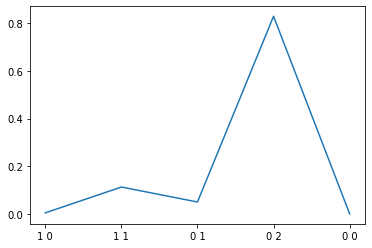

In [ ]:
probs = sim.state.stats.destribution
x = [key for key in probs]
y = [probs[key] for key in probs]
prob = np.sum(y)
plt.plot([key for key in probs],[probs[key] for key in probs])
print(probs)